# Pay Per Click Classifier

# Main Problem Definition
You are in the Data Science team at FlixBus. Your colleagues from the marketing department (specifically from the **PPC** (**P**ay **P**er **C**lick) team) came to you with a problem.

The PPC team handles the PPC ads, which are: for example, when you search for something on Google, and then some advertised results show up before the *organic* ones. For these ads FlixBus pays only when someone clicks on the ad, hence the name.

To help them manage such ads, Google provides them with daily data about the performance of their ads. This data includes (all on a daily basis):
* **clicks**: the number of clicks on the ad.
* **impressions**: the number of times the ad showed up (whether it was clicked or not).
* **cost**: the total cost that we paid (to Google) for the ad. (in microcents: 1e-6 €)
* **conversions**: the number of purchases. (fractions are normal and expected)
* **conversion_value**: the total revenue (in €)
* **ad_position**: the median position of the ad when it showed up
* **ad_location**: a derived variable we calculate describing where the ad showed up on the search results page (the top 3 positions show up on the top of the page, and the rest are displayed on the side of the page) (also a median)
 
The problem is: Google is soon deprecating the "ad position" parameters and is not going to provide them. The PPC team depends on these parameters to understand competition, market behaviour, and our ads' performance.
So they were wondering if we could use the rest of the performance metrics to predict the ad position; so we can continue to use it after Google deprecates it.

They provided you with the daily performance data of a specific ad for about 13 months.

## Tasks
1. Build a solution to predict the ad position.
2. (Optional bonus) Which ad position is most efficient for us? Where efficiency is defined as **revenue/cost**. (Don't forget to mention how much that efficiency is)
 

## Evaluation
Don't spend too much time on enhancing the prediction results. If the prediction results are unsatisfactory, you can just leave a note on why you think this is the case, and what you would try in order to enhance them (without actually needing to do that). The quality of your prediction is of course still a factor for the evaluation, but also how you evaluate your model, your approach of tackling the problem, your data handling, **the reproducibility of your results**, and the quality of your solution in general.

## How to submit
Our favourite approach is a Python Jupyter Notebook, but feel free to use another approach if you're more comfortable with it.
Make sure your solution can be understood and run on our side, as well as your results demonstrated.
Compress your solution into an archive and send it back using the link you were sent in the email.
(Optional: You may also send your solution as a git repo, but **please do not publish it publicly**.)

_________________

In [187]:
# Setup
import pandas as pd
import numpy as np
import pandas_profiling as pp
import seaborn as sns
from datetime import datetime
from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler

import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

In [188]:
# Import data
df = pd.read_csv('takehome_test_data.csv')

In [189]:
df.head()

,day,account,account_id,campaign,campaign_id,ad,ad_id,clicks,impressions,cost,conversions,conversion_value,ad_position,ad_location
0,2018-11-01,Google PPC Account,1312,Bus Campaign,156935,Munich - Berlin,1236985744,57,525,18030000.0,0.45,6.71,Fourth,Bottom of the page
1,2018-11-02,Google PPC Account,1312,Bus Campaign,156935,Munich - Berlin,1236985744,40,453,11300000.0,4.02,158.52,Third,Top of the page
2,2018-11-03,Google PPC Account,1312,Bus Campaign,156935,Munich - Berlin,1236985744,32,375,8640000.0,0.00,0.00,Third,Top of the page
3,2018-11-04,Google PPC Account,1312,Bus Campaign,156935,Munich - Berlin,1236985744,42,493,11790000.0,0.06,0.13,Fourth,Bottom of the page
4,2018-11-05,Google PPC Account,1312,Bus Campaign,156935,Munich - Berlin,1236985744,44,502,14060000.0,0.65,118.44,Third,Top of the page


In [190]:
df.dtypes

day                  object
account              object
account_id            int64
campaign             object
campaign_id           int64
ad                   object
ad_id                 int64
clicks                int64
impressions           int64
cost                float64
conversions         float64
conversion_value    float64
ad_position          object
ad_location          object
dtype: object

In [191]:
# Generate profiling report
prof = pp.ProfileReport(df)
prof.to_file(output_file='output.html')

Summarize dataset:   0%|          | 0/28 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [192]:
prof

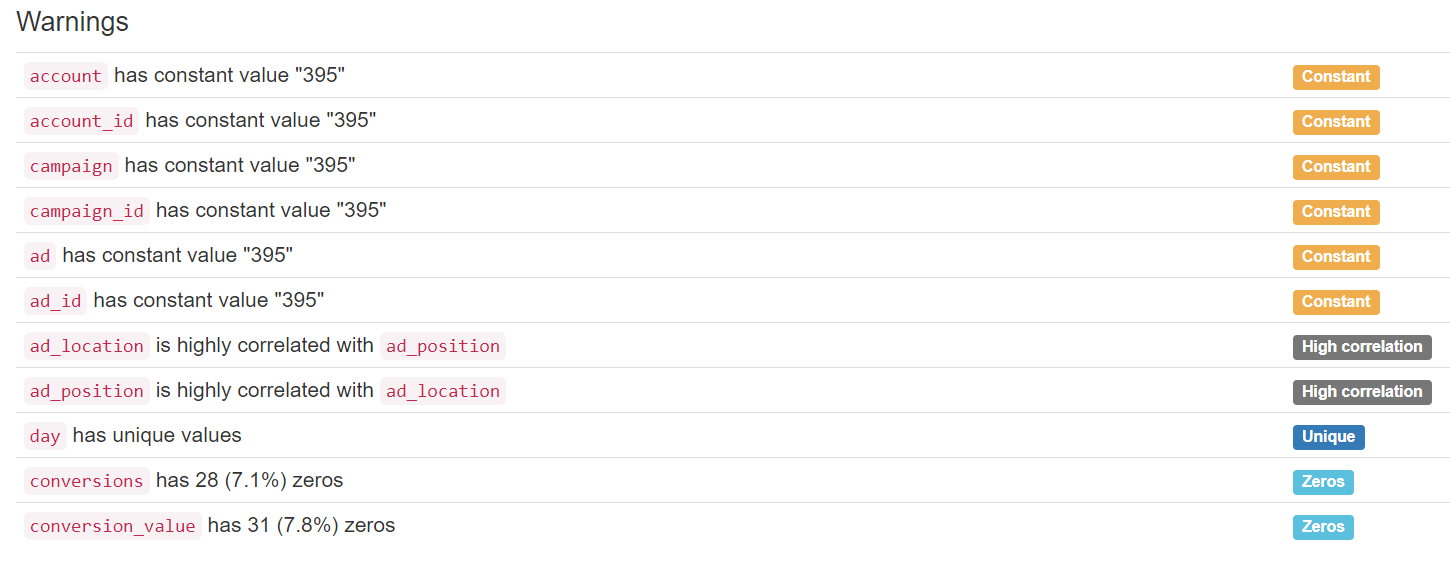

In [193]:
### DATA CLEANSING ###

# The only column with missing values is the feature cost
print(df.isnull().sum())

df[df['cost'].isnull()]

day                 0
account             0
account_id          0
campaign            0
campaign_id         0
ad                  0
ad_id               0
clicks              0
impressions         0
cost                3
conversions         0
conversion_value    0
ad_position         0
ad_location         0
dtype: int64


,day,account,account_id,campaign,campaign_id,ad,ad_id,clicks,impressions,cost,conversions,conversion_value,ad_position,ad_location
162,2019-05-12,Google PPC Account,1312,Bus Campaign,156935,Munich - Berlin,1236985744,73,594,NaN,0.12,2.96,Third,Top of the page
168,2019-05-18,Google PPC Account,1312,Bus Campaign,156935,Munich - Berlin,1236985744,58,417,NaN,0.88,21.62,Second,Top of the page
386,2019-02-24,Google PPC Account,1312,Bus Campaign,156935,Munich - Berlin,1236985744,60,704,NaN,0.13,0.13,Fourth,Bottom of the page


In [194]:
# As there should be a cost for every ad and there is a conversion_value (revenue) for those ads, 
# we should drop the rows with missing cost

df = df.dropna(subset=['cost'])

print(df.isnull().sum())

day                 0
account             0
account_id          0
campaign            0
campaign_id         0
ad                  0
ad_id               0
clicks              0
impressions         0
cost                0
conversions         0
conversion_value    0
ad_position         0
ad_location         0
dtype: int64


__________________

### Efficiency Measure

In [195]:
# efficiency = revenue/cost = conversion_value/cost

df['efficiency'] = df['conversion_value']/df['cost']

In [196]:
# Group efficiency by ad_position
df_eff_sum = df[['ad_position','efficiency']].groupby(by='ad_position', as_index=False).sum()
df_eff_sum

,ad_position,efficiency
0,Fifth,0.000008
1,First,0.000006
2,Fourth,0.000165
3,Second,0.000118
4,Third,0.000381


In [197]:
df_eff_sum[df_eff_sum['efficiency'] == df_eff_sum['efficiency'].max()]

,ad_position,efficiency
4,Third,0.000381


The most efficient ad position is the third.

________________________________

### Seasonality

In [198]:
# The day 2019-09-31 is included, but in reality it doesn't exist
df[df['day']=='2019-09-31']

,day,account,account_id,campaign,campaign_id,ad,ad_id,clicks,impressions,cost,conversions,conversion_value,ad_position,ad_location,efficiency
302,2019-09-31,Google PPC Account,1312,Bus Campaign,156935,Munich - Berlin,1236985744,128,1049,64030000.0,2.05,96.37,Fourth,Bottom of the page,0.000002


In [199]:
# The day 2019-09-30 doesn't exist, but 2019-10-01 exists
df[df['day']=='2019-09-30']

,day,account,account_id,campaign,campaign_id,ad,ad_id,clicks,impressions,cost,conversions,conversion_value,ad_position,ad_location,efficiency


In [200]:
# We can replace 2019-09-31 by 2019-09-30

df.loc[df['day']=='2019-09-31','day'] = '2019-09-30'

In [201]:
# Get date type column 
df['date'] = pd.to_datetime(df['day'])
df['date']

0     2018-11-01
1     2018-11-02
2     2018-11-03
3     2018-11-04
4     2018-11-05
         ...    
390   2018-12-11
391   2018-11-09
392   2018-12-07
393   2019-01-24
394   2018-11-08
Name: date, Length: 392, dtype: datetime64[ns]

In [202]:
# Check if dates are consecutive days

def is_consecutive(datelist):
    for idx, my_date in enumerate(datelist[:-1]):
        if ((datelist[idx + 1].month - my_date.month == 1 and
             datelist[idx + 1].year == my_date.year) or
            (datelist[idx + 1].month == 1 and
             my_date.month == 12 and
             datelist[idx + 1].year - my_date.year == 1)):
            continue
        else:
            print(idx, my_date)
            return False
        
    return True

date_list = df['date'].to_list()
date_list.sort()
is_consecutive(date_list)

0 2018-11-01 00:00:00


False

The only non-consecutive date is the start of the timeseries.

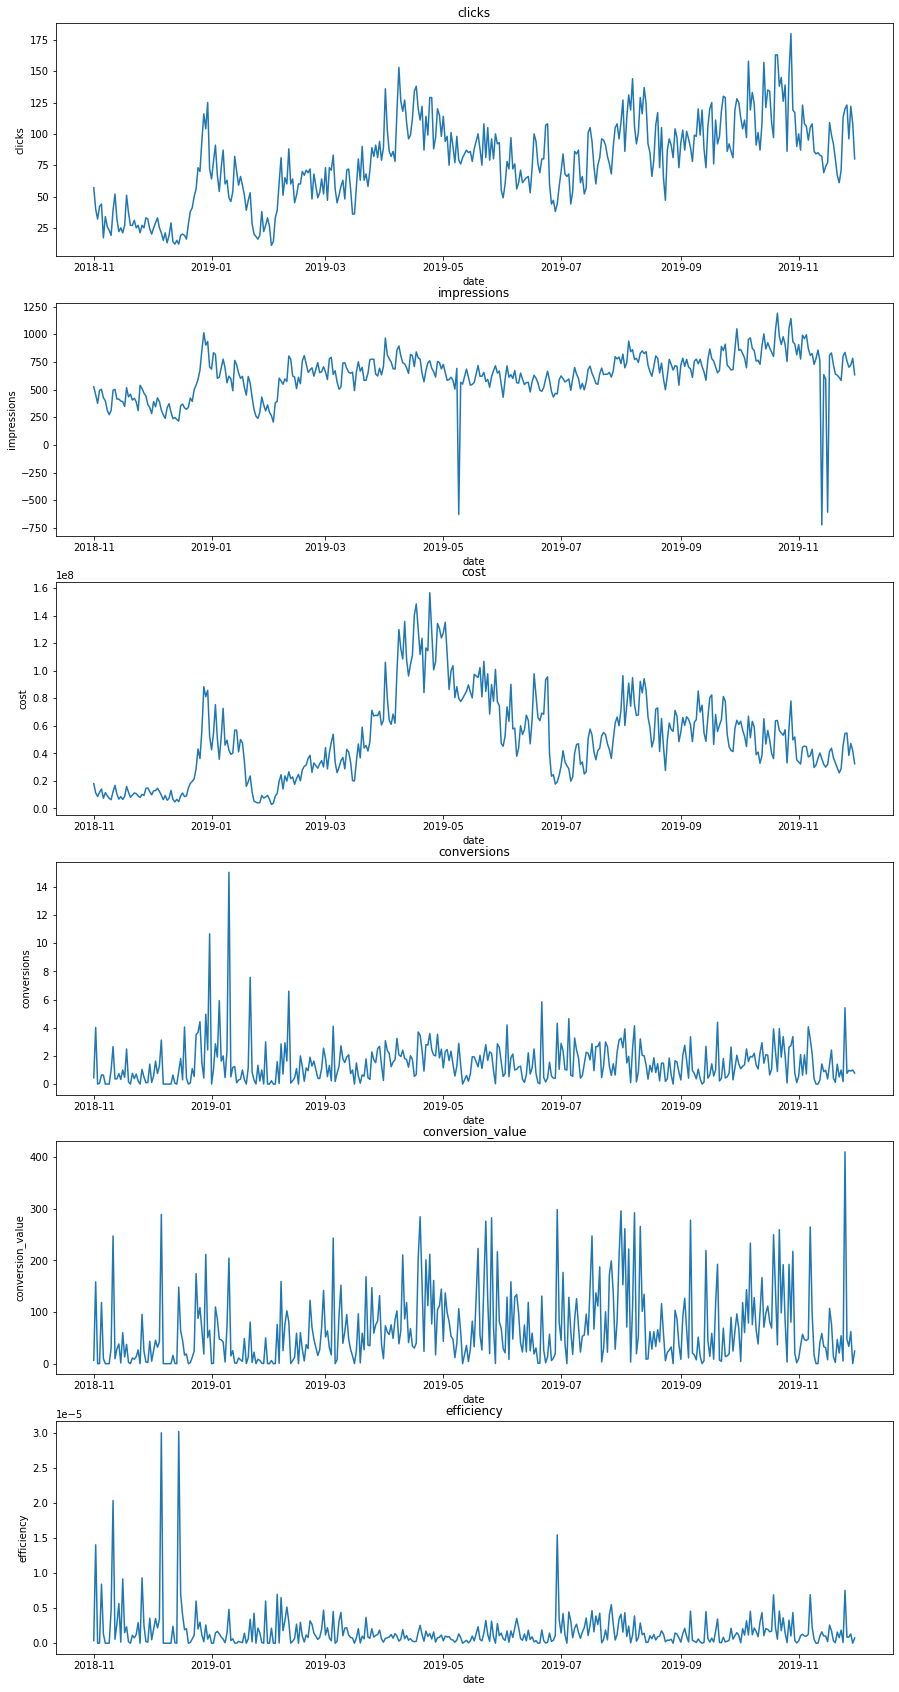

In [203]:
relevant_cols = ['clicks', 'impressions', 'cost', 'conversions','conversion_value',  'efficiency']

fig, axes = plt.subplots(6, 1, figsize=(15,30))

counter = 0
for col in relevant_cols:
    sns.lineplot(ax=axes[counter], data=df, y=col, x='date')
    axes[counter].set_title(col)
    counter += 1


The seasonal features seem to be important, as most of them vary quite much throughout time. Anyway we would need more historical data to understand it better.

In [204]:
# Adding seasonal columns
df['year'] = df['date'].dt.year
df['weekday'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month

# Weekends
df.loc[ (df['date'].dt.dayofweek == 6) | (df['date'].dt.dayofweek == 5) ,'is_weekend'] = 1
df = df.fillna(0)
df['is_weekend'] = df['is_weekend'].astype('int64')

_______________________________________________

### Model

In [205]:
# Manually encode ad_position feature
dict_map = dict({'First': 1,
                 'Second': 2,
                 'Third': 3,
                 'Fourth': 4,
                 'Fifth': 5})

df['cd_ad_position'] = df['ad_position'].str[:].map(dict_map)

In [213]:
# Label encode ad_location feature
le = preprocessing.LabelEncoder()
le.fit(df['ad_location'])
df['cd_ad_location'] = le.transform(df['ad_location'])

In [222]:
# Filter dataset for relevant features

df_model = df[['clicks', 'impressions', 'cost', 'conversions', 'conversion_value', #'efficiency',
               'year', 'weekday', 'month', 'is_weekend', 
               'cd_ad_position','cd_ad_location']]


In [227]:
# Split dataset into X and y
X = df_model.copy()
X.pop('cd_ad_position')
y = df_model[['cd_ad_position']]

In [230]:
# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)